# K-Means Clustering Implementation   
## Liam Quinlan
CS 339   
Dr. Kretchmar

In [436]:
# Importing Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path
datadir = "data"

### K-Means and associated functions

In [437]:
def kmeans(data, k):
    '''
    Performs K-Means clustering on the data with k centers

    Input:  Data, NumPy array
            k, int

    Output: Centers, a NumPy array of the coordinate of the centers
            Clusters, a one dimensional array of the cluster number associated with each data point
    '''
    # Initialization
    centers = np.zeros((k,data.shape[1]))
    new_centers = np.zeros((k,data.shape[1]))
    distances = np.ones((k,data.shape[0]))
    
    temp_data = data.copy()
    sample_indices = np.random.choice(temp_data.shape[0], k, replace=False)
    del temp_data
    
    centers = data[sample_indices]

    # Learning
    for _ in range(20):
        # Compute Distances
        for x in range(k):
            for y in range(0,data.shape[0]):
                distance = np.linalg.norm(centers[x] - data[y])
                distances[x][y] = distance

        # Identify closest clusters
        clusters = np.argmin(distances,axis=0)

        # Update centers
        for z in range(k):
            new_centers[z] = np.array(data[clusters == z].mean(axis=0))

        # Check for repeat centers
        does_array_repeat = centers == new_centers
        if np.all(does_array_repeat) == True:
            break

        centers = new_centers

    return centers, clusters

In [438]:
def normalize(data):
    '''
    Normalizes the data, subtracting each column by the minimum and dividing by the maximum

    Input:  Data, NumPy array

    Output: Normalized Data, NumPy array
    '''
    normalized_columns = []

    # Normalize each column independently
    for x in range(0,data.shape[1]):
        column = data[:,x]

        # Subtract by minimum
        min = np.min(column)
        column = column - min

        # Divide by maximum
        max = np.max(column)
        column = column / max

        # Append normalized columns to list
        normalized_columns.append(column)

    # Reorganize data into 2d array
    normalized_data = np.stack(normalized_columns, axis=1)

    return normalized_data

In [439]:
def standardize(data):
    '''
    Standardizes the data, subtracting each column by the mean and dividing by the standard deviation

    Input:  Data, NumPy array

    Output: Standardized Data, NumPy array
    '''
    standardized_columns = []

    # Standardize each column independently
    for x in range(0,data.shape[1]):
        column = data[:,x]

        # Calculate mean and standard deviation of column
        mean = np.mean(column)
        st_dev = np.std(column)

        # Standardize column
        column = (column - mean) / st_dev

        # Append standardized columns to list
        standardized_columns.append(column)

    # Reorganize data into 2d array
    standardized_data = np.stack(standardized_columns, axis=1)

    return standardized_data

In [440]:
def calculate_mse(data, centers, clusters):
    '''
    Calculates the mean squared error of the clustering, by calculating the MSE of each cluster relative to its center, and then taking the weighted average of all clusters

    Input:  Data, NumPy array
            Centers, a NumPy array of the coordinate of the centers
            Clusters, a one dimensional array of the cluster number associated with each data point

    Output: MSE, the mean squared error of the data set relative to the cluster centers
    '''
    average_squared_error_list = []
    cluster_size_list = []

    # Calculate mse for each cluster
    for x in range(0,centers.shape[0]):
        data_by_cluster = data[clusters == x]
        cluster_size = data_by_cluster.shape[0]

        # Calculate Squared Errors
        errors = data_by_cluster - centers[x]
        squared_errors = errors * errors

        # Take mean of Squared Errors
        mean_squared_error = np.mean(squared_errors)

        # Append MSE and cluster size to lists
        average_squared_error_list.append(mean_squared_error)
        cluster_size_list.append(cluster_size)

    # Calculate weighted average of mses
    for y in range(len(cluster_size_list)):
        average_squared_error_list[y] = average_squared_error_list[y] * cluster_size_list[y]

    squared_error_sum = np.sum(average_squared_error_list)
    mse = squared_error_sum / data.shape[0]

    return mse

In [441]:
def kmeans_wrapper(data, k, n):
    '''
    Runs K-Means n times with k centers, returning the minimum MSE and a NumPy array with the centers with the lowest MSE

    Input:  Data, NumPy array
            K, int representing the number of centers
            N, int representing the number of times K-Means will be run

    Output: Minimum MSE, int
            Best Centers, NumPy array
    '''
    mse_list = np.empty(0)
    centers_list = []
    
    # Run K-Means n times and store MSE for each run
    for _ in range(n):
        # Run K-Means
        centers, clusters = kmeans(data, k)
        
        # Calculate MSE
        mse = calculate_mse(data, centers, clusters)
        
        # Append MSE and centers to lists
        mse_list = np.append(mse_list, mse)
        centers_list.append(centers)

    # Get best run
    min_mse_index = np.argmin(mse_list)

    # Get minimum MSE and associated centers
    min_mse = np.min(mse_list)
    best_centers = centers_list[min_mse_index]

    return min_mse, best_centers

In [442]:
def elbow_plot(data, n):
    '''
    Runs K-Means on the data set n times, each time increasing the number of centers, displays a plot of the MSE of each run vs. the number of centers

    Input:  Data, NumPy array
            N, int representing the number of times K-Means will be called, and the range of k values that will be plotted

    Output: None, but plots the MSE of the clusterings for k values 0 to n
    '''
    # Create empty 2d array
    k_vs_mse_list = np.empty((0,2)) 

    # Run K-Means for each k value from 0 to n
    for k in range(1, n+1):
        # Run K-Means
        centers, clusters = kmeans(data, k)
        
        # Calculate MSE
        mse = calculate_mse(data, centers, clusters)
        
        # Add MSE and k to 2d array
        k_vs_mse = np.array([k, mse])
        k_vs_mse_list = np.append(k_vs_mse_list, [k_vs_mse], axis=0)

    # Plot 2d array
    plt.scatter(k_vs_mse_list[:,0], k_vs_mse_list[:,1])
    plt.show()

    return

In [443]:
def readData(filepath):
    '''
    Reads data from a filepath and returns a 2d List of Lists

    Input:  Filepath, a string which contains the location of the file with the desired data

    Output: List of Lists, a Python List of Lists containing the data
    '''
    file = open(filepath, 'r')
    LoL = []

    # Parse CSV and append to 2d list
    for line in file:
        vals = line.strip().split(',')
        temp_list = []
        for val in vals:
            temp_list.append(val)
        LoL.append(temp_list)

    file.close()

    return LoL

### Testing K-Means on a small dataset

Here, we will be testing our K-Means function on a small, two dimensional data set. We will begin by initializing a numpy array with 10 data points.

In [444]:
# initialize data
data1 = np.array([[1,2],[1,3],[1,5],[2,3],[2,1],[6,7],[5,6],[5,9],[7,6],[8,6]])
print(data1)

[[1 2]
 [1 3]
 [1 5]
 [2 3]
 [2 1]
 [6 7]
 [5 6]
 [5 9]
 [7 6]
 [8 6]]


We will now run K-Means on this data set with 2 centers, and we will plot the result. The blue dots are the data points, and the orange dots are the cluster centers.

[[1.4 2.8]
 [6.2 6.8]]


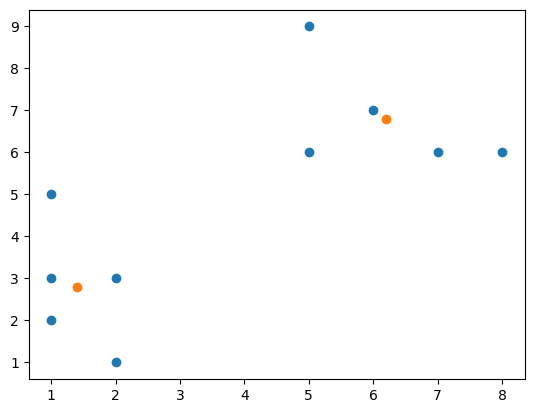

In [445]:
centers, clusters = kmeans(data1, 2)

plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

print(centers)
plt.show()

### Performing Cluster Analysis on S&P500 market data to encourage portfolio diversification

First, we load our data into a Pandas DataFrame.

In [446]:
listOfLists = readData(os.path.join(datadir, "financials.csv"))

financialsDF = pd.DataFrame(listOfLists[1:], columns=listOfLists[0])

financialsDF

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week High,52 Week Low,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.3328617,7.92,259.77,175.49,138721055226,9048000000,4.3902707,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.1479592,1.7,68.39,48.925,10783419933,601000000,3.5754826,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.9089824,0.26,64.6,42.28,102121042306,5744000000,3.7404804,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.4995599,3.29,125.86,60.05,181386347059,10310000000,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.7144699,5.44,162.6,114.82,98765855553,5643228000,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24,30.94,1.1700794,1.83,76.81,46.86,12915021000,722000000,2.7262094,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.3,27.25,1.7970798,4.07,86.93,62.85,27003303098,2289000000,6.3136363,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.7948336,9.01,133.49,108.17,24454698119,2007400000,3.1648953,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.6,55.61,38.43,10670678640,0,3.7945793,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...


We then clean our data by removing unnecessary columns and changing the data type of our desired columns from strings to integers.

In [447]:
financialsDFClean = financialsDF.copy()

columns_to_drop = ["Symbol","Name","Sector","Price","Price/Earnings","Earnings/Share","52 Week Low","52 Week High","EBITDA","Price/Sales","Price/Book","SEC Filings"]
financialsDFClean.drop(columns_to_drop, axis=1, inplace=True)

lf = lambda string_to_float: float(string_to_float)
financialsDFClean["Dividend Yield"] = financialsDFClean["Dividend Yield"].apply(lf)
financialsDFClean["Market Cap"] = financialsDFClean["Market Cap"].apply(lf)

financialsDFClean

,Dividend Yield,Market Cap
0,2.332862,1.387211e+11
1,1.147959,1.078342e+10
2,1.908982,1.021210e+11
3,2.499560,1.813863e+11
4,1.714470,9.876586e+10
...,...,...
500,1.170079,1.291502e+10
501,1.797080,2.700330e+10
502,0.794834,2.445470e+10
503,1.480933,1.067068e+10


Now, we convert our Pandas DataFrame to a NumPy array and normalize it. This normalization will help us to better view the data once we plot it.

In [448]:
financials_array = financialsDFClean.to_numpy()
financials_array = normalize(financials_array)

print(financials_array)

[[0.18425287 0.16866774]
 [0.09066752 0.01010968]
 [0.15077426 0.12330793]
 ...
 [0.06277713 0.02705302]
 [0.11696628 0.00996995]
 [0.05389475 0.04135055]]


We now put our data through our elbow plot function, testing up to 30 centers.

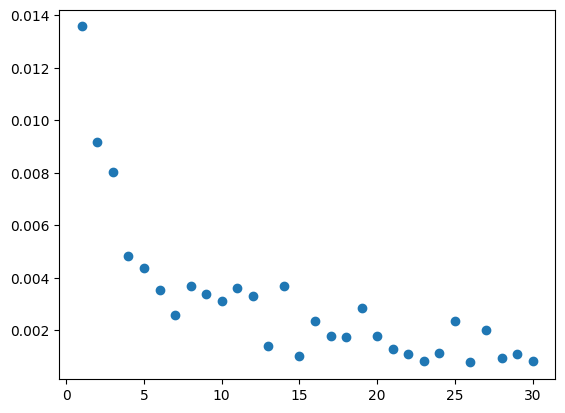

In [449]:
elbow_plot(financials_array, 30)

From the elbow plot, we determine that our optimal k value is between 5 and 10, so we choose 7. We now run our wrapper function with 7 as the number of centers and 10 as the number of iterations. 

In [450]:
best_mse, best_centers = kmeans_wrapper(financials_array, 7, 10)

print("Best MSE:\n", best_mse, "\n")
print("Best Centers:\n", best_centers)

Best MSE:
 0.0034014407189299416 

Best Centers:
 [[0.299279   0.02111227]
 [0.52066373 0.0216449 ]
 [0.3002463  0.15533925]
 [0.14466218 0.36731299]
 [0.02090145 0.02875555]
 [0.12503751 0.03580288]
 [0.20698871 0.03178767]]


Finally, we plot our data with the best centers.

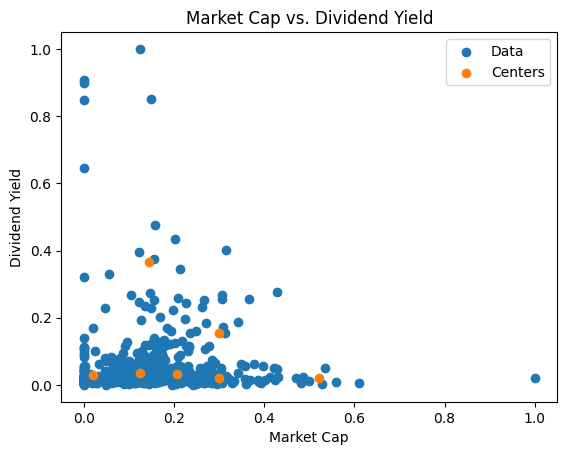

In [451]:
plt.scatter(financials_array[:, 0], financials_array[:, 1], label="Data")
plt.scatter(best_centers[:,0], best_centers[:,1], label="Centers")

plt.xlabel("Market Cap")
plt.ylabel("Dividend Yield")
plt.title("Market Cap vs. Dividend Yield")
plt.legend()

plt.show()